# Load and Perturbe Image

In [1]:
from __future__ import print_function, division
import cv2
import torch
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import gin
results_dir = 'results/'
example_name = "toyexample_6"

import os
import sys
gin.enter_interactive_mode()
module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
visualization_path = os.path.abspath(os.path.join('../../visualization'))
if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
if visualization_path not in sys.path:
    sys.path.append(visualization_path)
gin.enter_interactive_mode()

In [2]:
%load_ext autoreload
%autoreload 2



from FeaturePnP.model_old import sparseFeaturePnP
from FeaturePnP.helpers.utils import sobel_filter

In [3]:
toy_pickle_path = "data/%s_data.p" % example_name
toy_image_path = "data/%s.png" % example_name

In [4]:
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path)

In [5]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)
T_perturbed = np.array([[math.cos(4*math.pi/180), -math.sin(4*math.pi/180), 0, 0],
             [math.sin(4*math.pi/180), math.cos(4*math.pi/180), 0, 0],
             [0, 0, 1, 0]])

In [6]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [7]:
data['K']

array([[ 50.,   0., 512.],
       [  0.,  50., 512.],
       [  0.,   0.,   1.]])

In [8]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [9]:
# Round double coords to ints -> to use as index in matrix
coords_2d = np.around(projected_2d)
coords_2d = coords_2d.astype(int) - 1

In [10]:
# Draw perturbed points into original image
img = img.astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(img, tuple(p), 4, (128, 128, 0), -1)

0 [492 828]
1 [742 489]
2 [294 189]
3 [893 680]
4 [152 822]
5 [557 329]
6 [375  94]
7 [434 863]
8 [ 19 776]
9 [736 292]
10 [852 462]
11 [425 676]
12 [182 319]
13 [165 295]


True

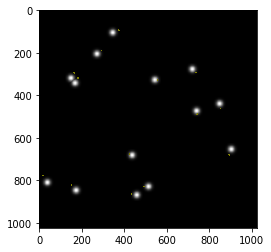

In [11]:
# Show image with perturbed points + Write
plt.imshow(img)
cv2.imwrite(results_dir + example_name + '_perturbed_points.png', img)

# Feature BA

In [12]:

from model import optimizer_step, indexing_

from helpers.utils import (from_homogeneous, to_homogeneous,
                batched_eye_like, skew_symmetric, so3exp_map)

from helpers.utils import squared_loss, scaled_loss

from torch.nn.functional import interpolate

In [13]:
# Reload image as doubles
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path,0)
img = img.astype('double')

In [14]:
# Create image tensor
img_torch = torch.from_numpy(img)[None,...]

# Convolve Sobel Filter to extract x and y gradient: 1xHxW
grad_x, grad_y = sobel_filter(img_torch)

In [42]:
%%capture
# Exemplary, Show perturbed points on the y-gradient of the image. Resized to 128x128
"""
grad_y_img = grad_y.numpy().reshape(img.shape).astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(grad_y_img, tuple(p), 1, (128, 128, 0), -1)
plt.imshow(grad_y_img)
cv2.imwrite(results_dir+example_name + "_grad_x.png", grad_x.numpy().reshape(img.shape).astype('uint8'))
cv2.imwrite(results_dir+example_name + "_grad_y.png", grad_y.numpy().reshape(img.shape).astype('uint8'))
"""

In [43]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)

angle = 4

offset_x = 0
offset_y = 0
offset_z = -0.1
T_perturbed = np.array([[math.cos(angle*math.pi/180), -math.sin(angle*math.pi/180), 0,offset_x],
             [math.sin(angle*math.pi/180), math.cos(angle*math.pi/180), 0, offset_y],
             [0, 0, 1, offset_z]])
print(T_perturbed)

[[ 0.99756405 -0.06975647  0.          0.        ]
 [ 0.06975647  0.99756405  0.          0.        ]
 [ 0.          0.          1.         -0.1       ]]


In [44]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [45]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]
print(projected_2d)

[[4.92815979e+02 8.37233014e+02]
 [7.53906831e+02 4.88904136e+02]
 [2.89473453e+02 1.81525894e+02]
 [9.04614484e+02 6.85690278e+02]
 [1.36149181e+02 8.37458061e+02]
 [5.59617074e+02 3.24952818e+02]
 [3.71216374e+02 8.21509553e+01]
 [4.31456816e+02 8.81917156e+02]
 [1.90497612e-01 7.87511695e+02]
 [7.42658037e+02 2.87123609e+02]
 [8.64234067e+02 4.61636462e+02]
 [4.23655203e+02 6.81273400e+02]
 [1.73187073e+02 3.14020019e+02]
 [1.56167441e+02 2.89803797e+02]]


In [95]:
# Define image size
im_height, im_width = img.shape
# Load 3D Points
pts3D = torch.from_numpy(data['3d_points'][:,:3])
# Load 2D Points in reference image: [[x1,y1], ....]
ref2d = torch.from_numpy(np.flip(data['coords'], axis = 1).copy())
# 2D Tensor with intensity at reference feature pixel (= center of gaussian = 255)-> [[255],[255], ...] NFx1
feature_ref = torch.cat([img_torch[:, i, j].unsqueeze(0) for i, j in zip(ref2d[:,0], ref2d[:,1])]).type(torch.DoubleTensor)
feature_map_query = img_torch.type(torch.DoubleTensor)

#Load initial rotation and translation for query image (=perturbed image)
R_init, t_init = torch.from_numpy(T_perturbed[:, :3]), torch.from_numpy(T_perturbed[:, 3])
feature_grad_x = grad_x
feature_grad_y = grad_y

# Camera intrinsics tensor 3x3
K = torch.from_numpy(data['K'])

# K=K/8.0

# K[2,2]=1.0

print(K)


hypercolumn_size = (128,128)
#Test: Downsample feature by 8x8 using bilinear
feature_map_query = interpolate(feature_map_query.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0) #interpolate needs 4D tensor, I add batch dimension
feature_grad_x = interpolate(feature_grad_x.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)
feature_grad_y = interpolate(feature_grad_y.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)

feature_map_query.shape

tensor([[ 50.,   0., 512.],
        [  0.,  50., 512.],
        [  0.,   0.,   1.]], dtype=torch.float64)


torch.Size([1, 128, 128])

In [154]:
# Set runtime parameters
n_iters = 50
lambda_ = 0.1 # regularization
verbose=True

In [155]:
from FeaturePnP.model_old import sparseFeaturePnP
# Load actual model
model = sparseFeaturePnP(n_iters = n_iters, lambda_ = lambda_, verbose=verbose)
K[..., [0, 1], [0, 1]]
K[..., [0, 1], [2, 2]]

tensor([512., 512.], dtype=torch.float64)

In [156]:
# Run the model -> this calls the forward method of model
from FeaturePnP.model_old import sparseFeaturePnP, interpolate_tensor
# Load actual model
model = sparseFeaturePnP(n_iters = n_iters, lambda_ = lambda_, verbose=verbose)

R, t, cost_init, cost_final = model(pts3D, feature_ref, feature_map_query, feature_grad_x, feature_grad_y, K , R_init, \
              t_init, 1024, 1024, track = True)

print(cost_init, cost_final)

"""
tensor([[ 16.5000],
        [ 15.0000],
        [  1.2500],
        [  1.2500],
        [  0.0000],
        [126.5000],
        [  0.7500],
        [  0.0000],
        [ 32.7500],
        [ 17.2500],
        [ 56.2500],
        [ 25.5000],
        [  5.2500]], dtype=torch.float64)"""

Old False
tensor([[492.8160, 837.2330],
        [753.9068, 488.9041],
        [289.4735, 181.5259],
        [904.6145, 685.6903],
        [136.1492, 837.4581],
        [559.6171, 324.9528],
        [371.2164,  82.1510],
        [431.4568, 881.9172],
        [742.6580, 287.1236],
        [864.2341, 461.6365],
        [423.6552, 681.2734],
        [173.1871, 314.0200],
        [156.1674, 289.8038]], dtype=torch.float64)
tensor([[ 16.5000],
        [ 15.0000],
        [  1.2500],
        [  1.2500],
        [  0.0000],
        [126.5000],
        [  0.7500],
        [  0.0000],
        [ 32.7500],
        [ 17.2500],
        [ 56.2500],
        [ 25.5000],
        [  5.2500]], dtype=torch.float64)
Iter  0 27497.41105769231
new cost is  28527.571428571428
tensor([[492.8160, 837.2330],
        [753.9068, 488.9041],
        [289.4735, 181.5259],
        [904.6145, 685.6903],
        [136.1492, 837.4581],
        [559.6171, 324.9528],
        [371.2164,  82.1510],
        [431.4568, 881.9172]

new cost is  264.63392857142856
tensor([[515.0646, 829.7683],
        [740.4723, 474.5868],
        [273.0463, 206.0347],
        [904.1008, 654.3349],
        [174.7971, 847.7702],
        [545.2394, 328.0241],
        [346.6838, 106.2308],
        [459.4553, 869.1505],
        [ 39.3827, 810.6940],
        [720.6249, 278.3305],
        [848.5037, 440.1434],
        [437.4160, 682.5775],
        [170.1050, 343.3678],
        [151.3818, 320.6986]], dtype=torch.float64)
tensor([[251.7500],
        [247.0000],
        [237.5000],
        [237.5000],
        [240.0000],
        [226.2500],
        [244.5000],
        [254.0000],
        [233.0000],
        [237.5000],
        [226.2500],
        [244.5000],
        [240.0000],
        [224.2500]], dtype=torch.float64)
Iter  22 169.55357142857142
new cost is  189.58928571428572
tensor([[515.0646, 829.7683],
        [740.4723, 474.5868],
        [273.0463, 206.0347],
        [904.1008, 654.3349],
        [174.7971, 847.7702],
        [545.2

tensor([[515.0637, 829.7654],
        [740.4679, 474.5896],
        [273.0462, 206.0379],
        [904.0971, 654.3354],
        [174.8033, 847.7651],
        [545.2378, 328.0267],
        [346.6829, 106.2344],
        [459.4545, 869.1455],
        [ 39.3920, 810.6896],
        [720.6233, 278.3322],
        [848.5007, 440.1453],
        [437.4158, 682.5770],
        [170.1071, 343.3713],
        [151.3839, 320.7021]], dtype=torch.float64)
tensor([[251.7500],
        [247.0000],
        [237.5000],
        [237.5000],
        [240.0000],
        [226.2500],
        [244.5000],
        [254.0000],
        [233.0000],
        [237.5000],
        [226.2500],
        [244.5000],
        [240.0000],
        [224.2500]], dtype=torch.float64)
Iter  40 169.55357142857142
new cost is  169.55357142857142
tensor([[515.0637, 829.7654],
        [740.4679, 474.5896],
        [273.0462, 206.0379],
        [904.0971, 654.3354],
        [174.8033, 847.7650],
        [545.2378, 328.0267],
        [346.682

'\ntensor([[ 16.5000],\n        [ 15.0000],\n        [  1.2500],\n        [  1.2500],\n        [  0.0000],\n        [126.5000],\n        [  0.7500],\n        [  0.0000],\n        [ 32.7500],\n        [ 17.2500],\n        [ 56.2500],\n        [ 25.5000],\n        [  5.2500]], dtype=torch.float64)'

In [157]:
cost_list = model.track_["costs"]
point_list = torch.stack(model.track_["points2d"])
R_list = model.track_["Rs"]
t_list = model.track_["ts"]
P_perturbed = np.dot(data['K'], T_perturbed)
from FeaturePnP.model_old import sparseFeaturePnP, interpolate_tensor, indexing_
# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

print(cost_list[0], cost_list[-2:])

#print(cost_list)
pts = torch.Tensor([[6.1602e+01, 1.0465e+02]])*8
print(pts)

pts = pts.type(torch.DoubleTensor)
print("Indexing_",indexing_(feature_map_query, torch.flip(pts, (1,)), 1024, 1024))
print("Bilinear",interpolate_tensor(feature_map_query,pts))
print(feature_map_query[:,105,62])
print(feature_map_query[:,104,62])
# print(projected_2d)
# print(T_perturbed)
# cost_list


pts = torch.Tensor([[94,61]]) / 127 * 2 -1
pts = pts.type(torch.DoubleTensor)
tensor_out = torch.nn.functional.grid_sample(
        feature_map_query[None], pts[None, None], mode='nearest', align_corners=True)
print(tensor_out.reshape(1, -1).t())

print(cost_list)

27497.41105769231 [169.55357142857142, 189.58928571428572]
tensor([[492.8160, 837.2000]])
Indexing_ tensor([[16.5000]], dtype=torch.float64)
Bilinear tensor([[16.5000]], dtype=torch.float64)
tensor([28.5000], dtype=torch.float64)
tensor([70.2500], dtype=torch.float64)
tensor([[15.]], dtype=torch.float64)
[27497.41105769231, 28527.571428571428, 24927.04910714286, 19466.14285714286, 24179.390625, 18421.698660714286, 23960.537946428572, 15060.71205357143, 6360.395089285715, 893.0736607142857, 655.1517857142857, 453.734375, 430.12276785714283, 189.58928571428572, 220.21651785714286, 169.55357142857142, 264.63392857142856, 169.55357142857142, 264.63392857142856, 189.58928571428572, 189.58928571428572, 169.55357142857142, 264.63392857142856, 189.58928571428572, 189.58928571428572, 169.55357142857142, 264.63392857142856, 189.58928571428572, 189.58928571428572, 169.55357142857142, 203.73214285714286, 189.58928571428572, 169.55357142857142, 189.58928571428572, 169.55357142857142, 189.5892857142

# Visualization

In [158]:
import visualization.plot_3d_tools as plot_3d
from visualization.create_video import *

In [159]:
# get final cost to see if visualization makes sense (Should be really low)
print(cost_list[0])
print(cost_list[-1])
print(R, R_init)
print(t)

27497.41105769231
189.58928571428572
tensor([[ 1.0000e+00, -3.9051e-04, -4.6188e-07],
        [ 3.9051e-04,  1.0000e+00,  3.1400e-05],
        [ 4.4962e-07, -3.1400e-05,  1.0000e+00]], dtype=torch.float64) tensor([[ 0.9976, -0.0698,  0.0000],
        [ 0.0698,  0.9976,  0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64)
tensor([-1.5305e-02,  2.2470e-02, -3.5163e-05], dtype=torch.float64)


In [160]:
%%capture
frames = frames_from_track(toy_image_path, model.track_, n_iters)

In [161]:
# Create video out of image list
height, width, layers = frames[0].shape
#framerate (frames/second)
fr = 2
video= cv2.VideoWriter(results_dir + example_name + "_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 2, (width,height))
for image in  frames:
    video.write(image)
video.release()

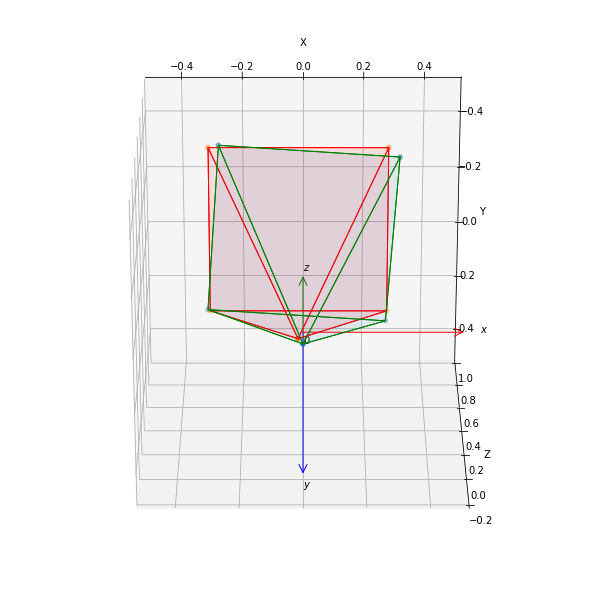

In [162]:
# Visualize camera pose  in 3D (example)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Draw Coordinate frame
plot_3d.plot_coordinate_system(ax, size = (0.5,0.5,0.5))

# Plot initial camera pose (green pyramid)
plot_3d.plot_camera(ax,R_init.numpy(),t_init.numpy(), edgecolor="g", facecolor=None, alph=0.05)

# Plot final camera pose (red pyramid)
plot_3d.plot_camera(ax,R.numpy(),t.numpy(), edgecolor="r", facecolor="r", alph=0.05)

# Adjust Angle of 3D plot view
ax.view_init(elev=-65, azim=-90)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.2, 1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# ToDo: Scatter the 3D points in this plot

# Show Plot
plt.show()

In [163]:
plt.imshow(img_list[0])

NameError: name 'img_list' is not defined

In [ ]:
new_proj_1[mask,:]
